In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
import matplotlib.pyplot as plt
#from sklearn.svm import SVC
#from sklearn.inspection import partial_dependence, plot_partial_dependence

In [2]:
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
import dice_ml

## Preparing Data

In [4]:
df = pd.read_csv("Breast-Cancer-Data.csv")
df.head(5)

,Diagnosis,Mean Radius,Mean Texture,Mean Perimeter,Mean Area,Mean Smoothness,Mean Compactness,Mean Concavity,Mean Concave Points,Mean Symmetry,...,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Compactness,Worst Concavity,Worst Concave Points,Worst Symmetry,Worst Fractal Dimension
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [5]:
Breast_Cancer_df = df.copy()

In [6]:
Breast_Cancer_df["Diagnosis"] = Breast_Cancer_df["Diagnosis"].map({'B':0, 'M':1})

In [7]:
target = Breast_Cancer_df['Diagnosis'].copy()
data_points = Breast_Cancer_df.drop('Diagnosis', axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data_points, target, test_size=0.2, random_state=0)

In [9]:
scaler = StandardScaler()
mlp_clf = MLPClassifier(hidden_layer_sizes=(30, 20), activation='relu', solver='sgd',batch_size=32, alpha= 0.0001, learning_rate='constant', learning_rate_init=0.0550, 
                                 max_iter=70, momentum=0.95)
mlp_pipe = Pipeline([('scaler', scaler), ('mlp', mlp_clf)])

In [10]:
mlp_pipe.fit(X_train, y_train)
mlp_pipe.score(X_test, y_test)

0.9824561403508771

## SHAP

In [15]:
explainer = shap.PermutationExplainer(mlp_pipe.predict_proba, X_train)
shap_vals = explainer(X_train)

PermutationExplainer explainer: 456it [00:25, 10.99it/s]                         


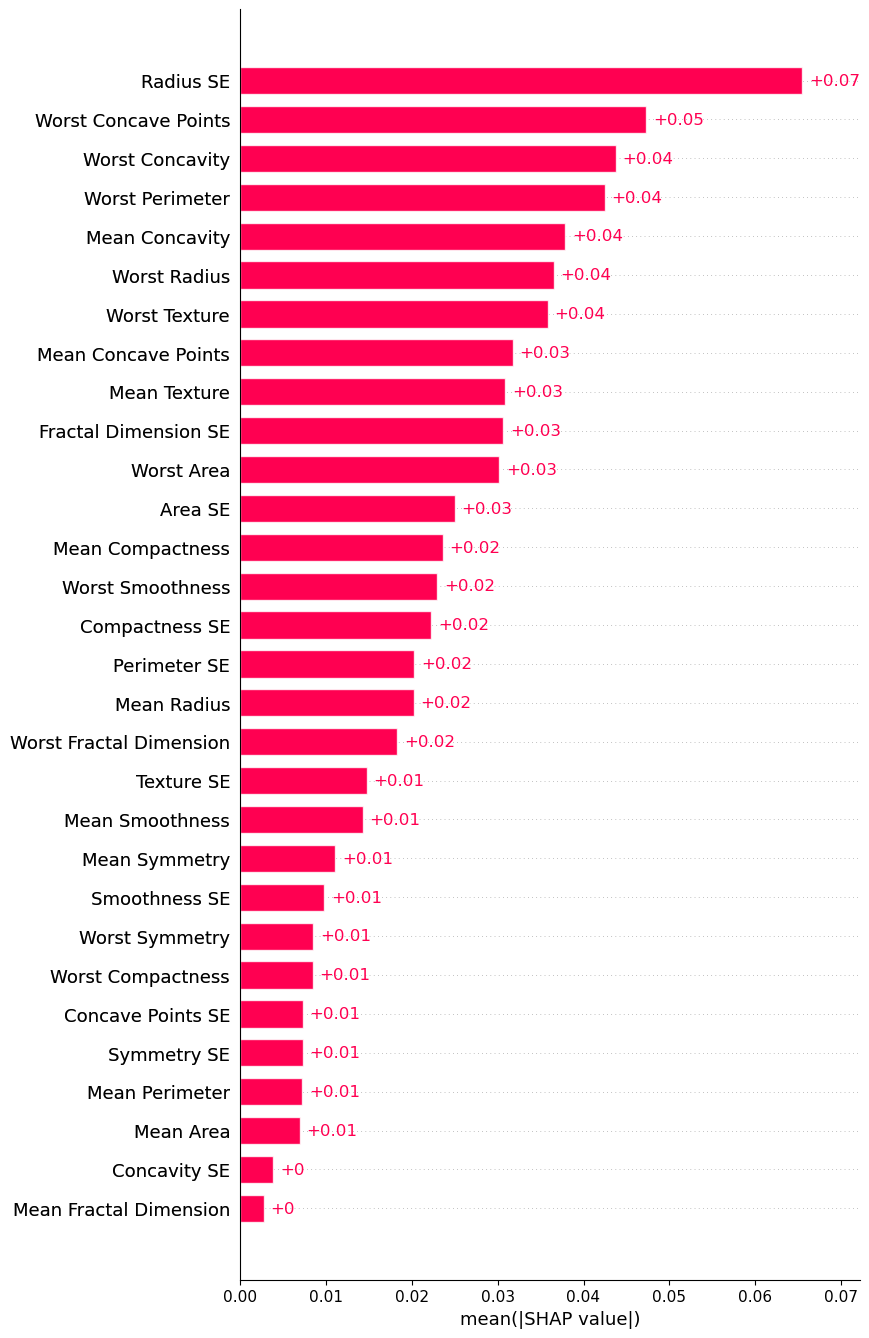

In [17]:
shap.plots.bar(shap_vals[:, :, 1], max_display=30)

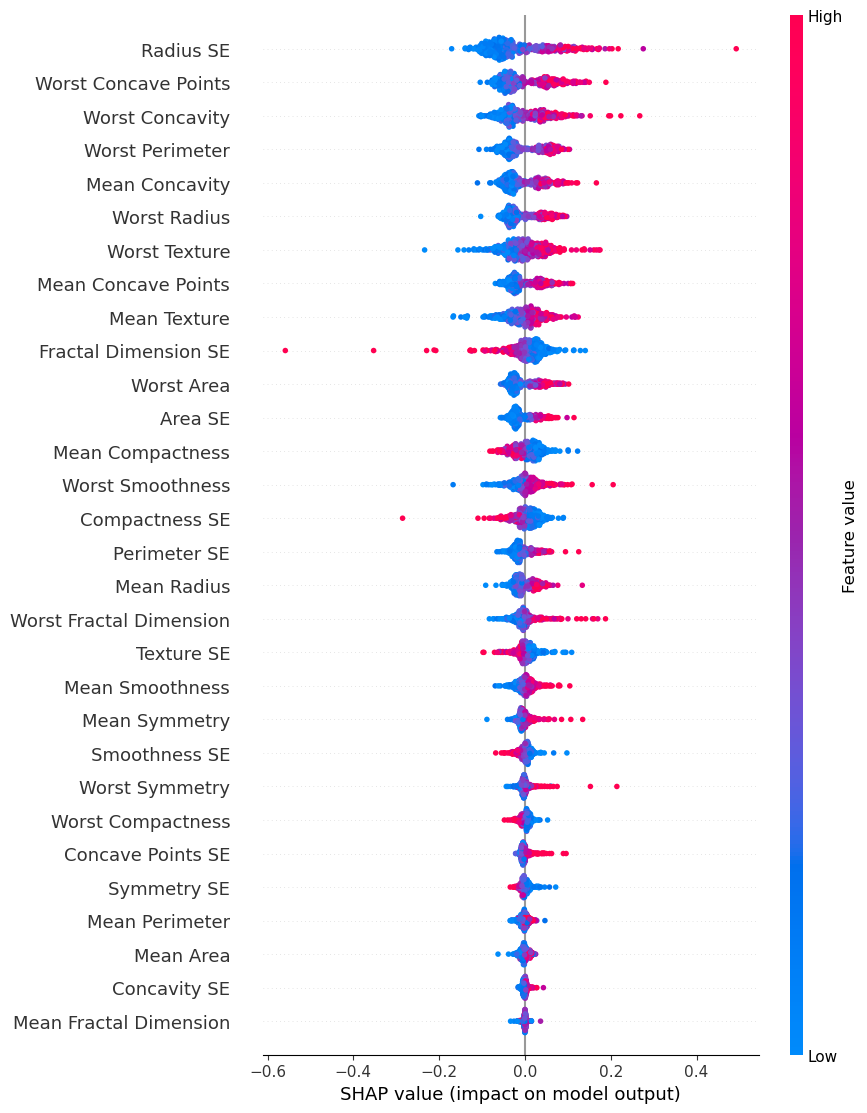

In [18]:
shap.plots.beeswarm(shap_vals[:, :, 1], max_display=30)

## Using SHAP for feature selection

In [28]:
shap_selected_features = Breast_Cancer_df.drop(['Mean Fractal Dimension', 'Concave Points SE', 'Symmetry SE', 'Texture SE', 'Smoothness SE', 'Concavity SE',
                                           'Worst Symmetry', 'Mean Symmetry', 'Mean Compactness', 'Mean Perimeter', 'Mean Area', 'Worst Compactness', 'Mean Smoothness', 
                                           'Perimeter SE', 'Mean Radius'], axis=1)

In [29]:
target2 = Breast_Cancer_df['Diagnosis'].copy()

In [30]:
train_data2, test_data2, y_train2, y_test2 = train_test_split(shap_selected_features, target2, test_size=0.2, random_state=0)
X_train2 = train_data2.drop('Diagnosis', axis=1)
X_test2 = test_data2.drop('Diagnosis', axis=1)

In [31]:
mlp_clf2 = MLPClassifier(hidden_layer_sizes=(30, 20), activation='relu', solver='sgd',batch_size=32, alpha= 0.0001, learning_rate='constant', learning_rate_init=0.0550, 
                                 max_iter=95, momentum=0.95)
scaler2 = StandardScaler()
mlp_pipe2 = Pipeline([('scaler', scaler2), ('mlp', mlp_clf2)])

In [43]:
mlp2_scores = cross_validate(mlp_pipe2, X_train2, y_train2, scoring=('precision', 'recall', 'f1', 'accuracy'), cv=10, return_train_score=True)
print("test precision: ", mlp2_scores['test_precision'].mean())
print("test recall: ", mlp2_scores['test_recall'].mean())
print("test f1: ", mlp2_scores['test_f1'].mean())
print("test accuracy: ", mlp2_scores['test_accuracy'].mean())

print("train f1: ", mlp2_scores['train_f1'].mean())
print("train accuracy: ", mlp2_scores['train_accuracy'].mean())

test precision:  0.9826797385620916
test recall:  0.9522058823529411
test f1:  0.9658255090892662
test accuracy:  0.9759420289855072
train f1:  1.0
train accuracy:  1.0


In [44]:
model2 = mlp_pipe2.fit(X_train2, y_train2)

In [45]:
mlp_pipe2_predictions = mlp_pipe2.predict(X_test2)
print(mlp_pipe2_predictions)

[1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 1 0 1 0 0 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 1
 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 0 0
 1 1 0]


In [46]:
mlp_pipe2_precision = precision_score(y_test2, mlp_pipe2_predictions)
mlp_pipe2_recall = recall_score(y_test2, mlp_pipe2_predictions)
mlp_pipe2_f1 = f1_score(y_test2, mlp_pipe2_predictions)
mlp_pipe2_accuracy = mlp_pipe2.score(X_test2, y_test2)

print("Precision: ", mlp_pipe2_precision)
print("Recall: ", mlp_pipe2_recall)
print("f1: ", mlp_pipe2_f1)
print("Accuracy: ", mlp_pipe2_accuracy)

Precision:  0.9787234042553191
Recall:  0.9787234042553191
f1:  0.9787234042553191
Accuracy:  0.9824561403508771


## SHAP for new model

In [47]:
explainer2 = shap.PermutationExplainer(mlp_pipe2.predict_proba, X_train2)
shap_vals2 = explainer2(X_test2)

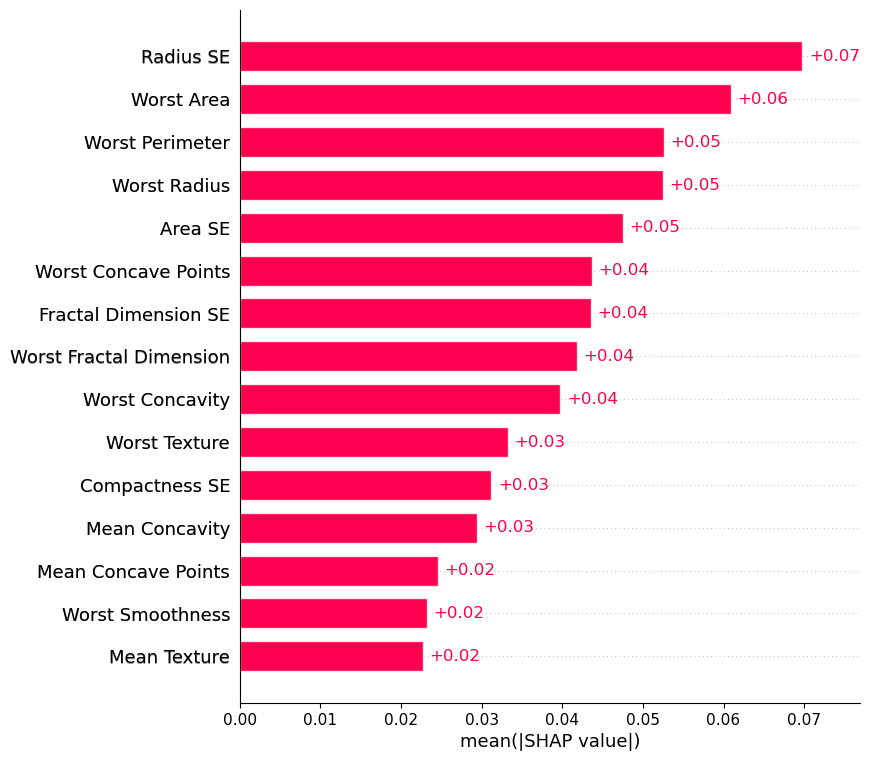

In [52]:
shap.plots.bar(shap_vals2[:, :, 1], max_display=15)

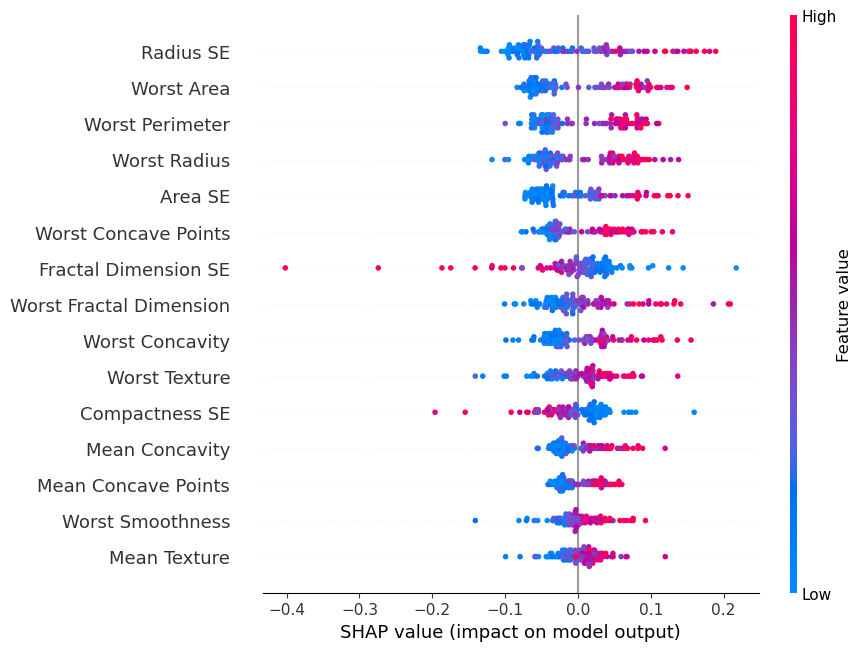

In [53]:
shap.plots.beeswarm(shap_vals2[:, :, 1], max_display=15)

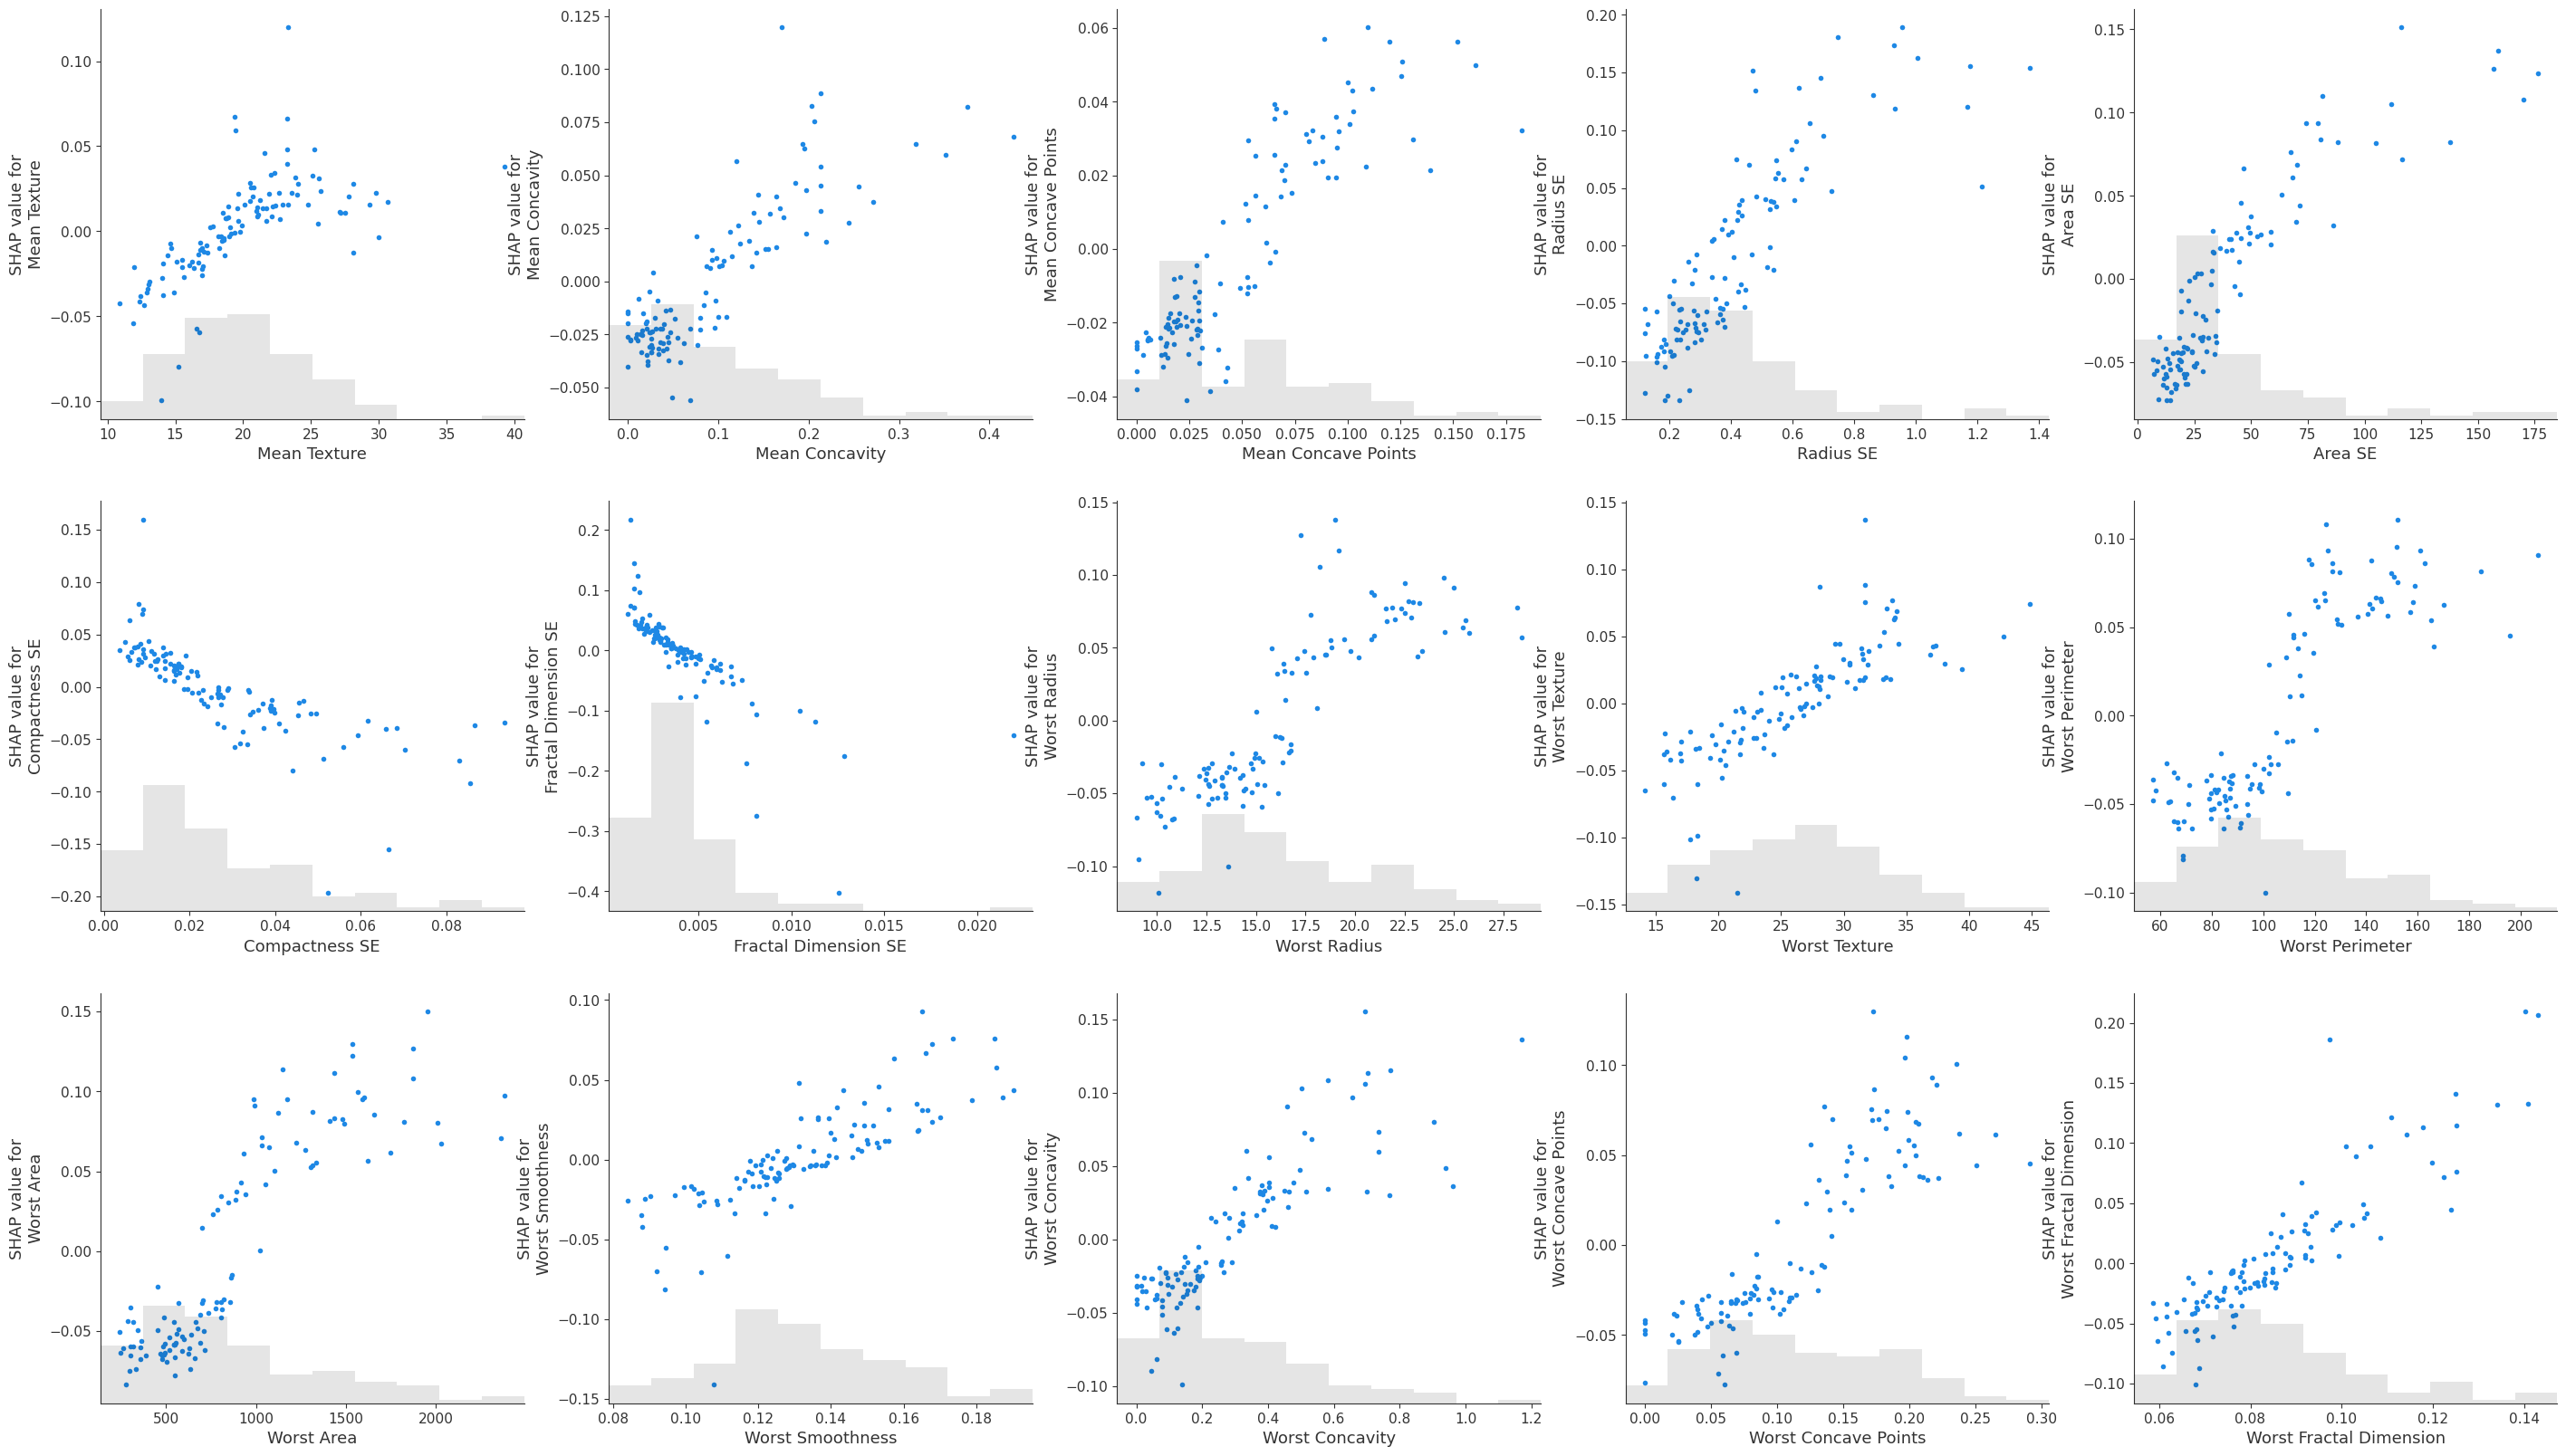

In [54]:
fig, axs = plt.subplots(3, 5, figsize=(35,20))

shap.plots.scatter(shap_vals2[:, "Mean Texture", 1], ax=axs[0,0], show = False)
shap.plots.scatter(shap_vals2[:, "Mean Concavity", 1], ax=axs[0,1], show = False)
shap.plots.scatter(shap_vals2[:, "Mean Concave Points", 1], ax=axs[0,2], show = False)
shap.plots.scatter(shap_vals2[:, "Radius SE", 1], ax=axs[0,3], show = False)
shap.plots.scatter(shap_vals2[:, "Area SE", 1], ax=axs[0,4], show = False)

shap.plots.scatter(shap_vals2[:, "Compactness SE", 1], ax=axs[1,0], show = False)
shap.plots.scatter(shap_vals2[:, "Fractal Dimension SE", 1], ax=axs[1,1], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Radius", 1], ax=axs[1,2], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Texture", 1], ax=axs[1,3], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Perimeter", 1], ax=axs[1,4], show = False)

shap.plots.scatter(shap_vals2[:, "Worst Area", 1], ax=axs[2,0], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Smoothness", 1], ax=axs[2,1], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Concavity", 1], ax=axs[2,2], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Concave Points", 1], ax=axs[2,3], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Fractal Dimension", 1], ax=axs[2,4], show = False)

plt.show()

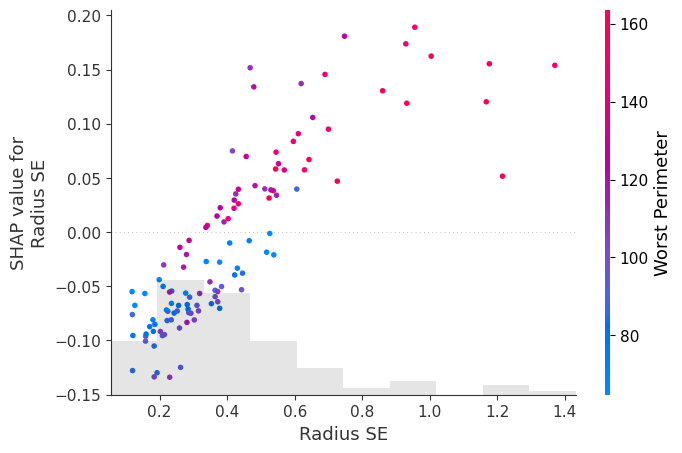

In [161]:
shap.plots.scatter(shap_vals2[:, "Radius SE", 1], show = False, color=shap_vals2[:,:,1])

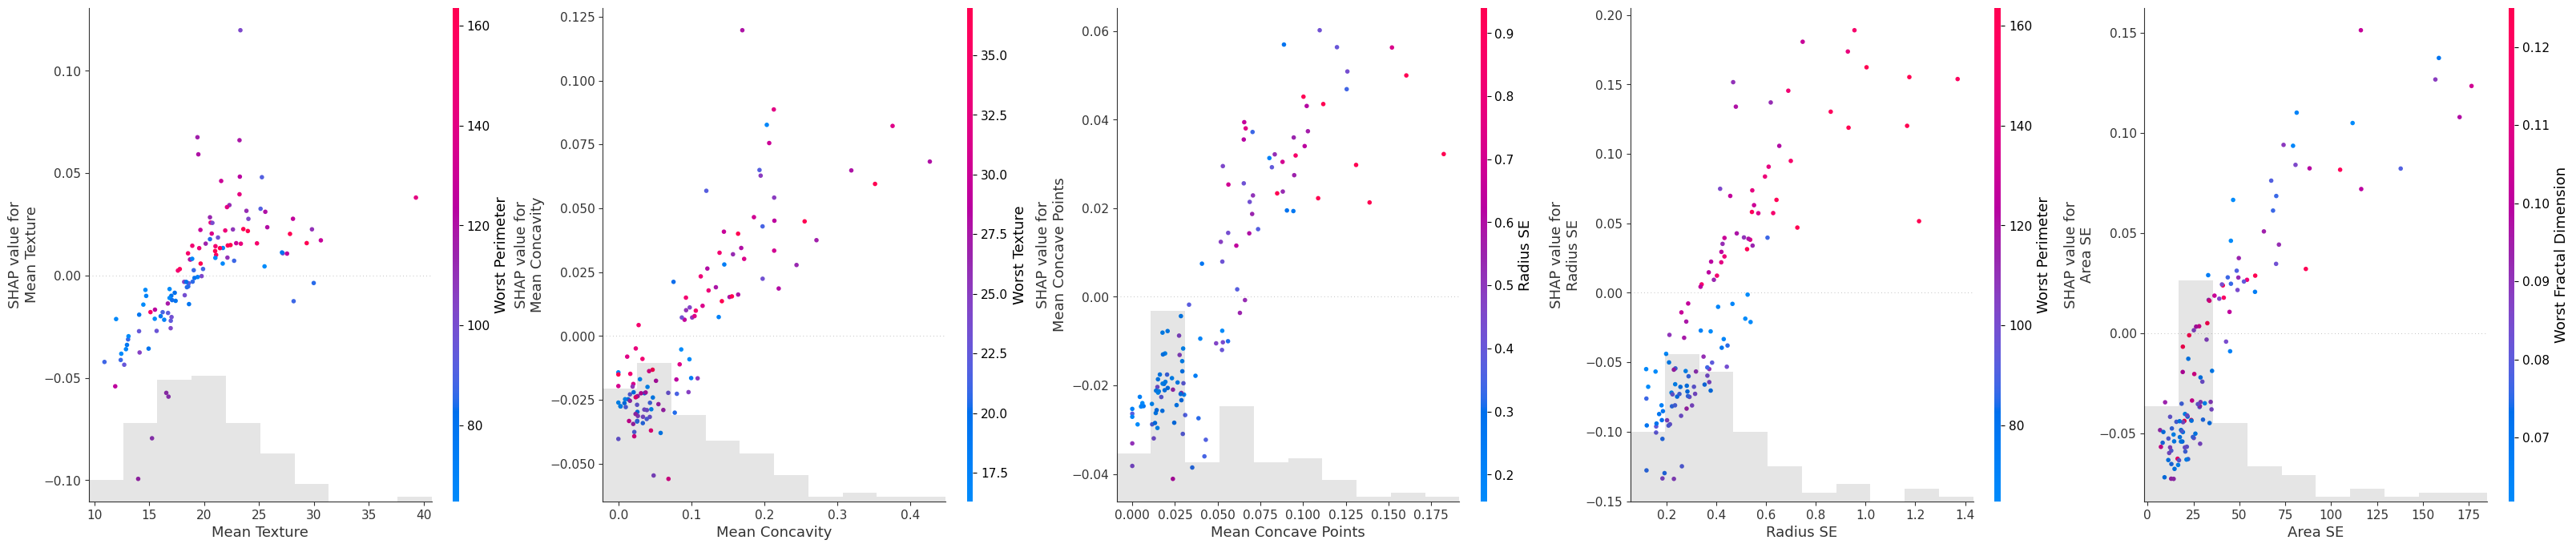

In [56]:
fig, axs = plt.subplots(1, 5, figsize=(40, 8))

shap.plots.scatter(shap_vals2[:, "Mean Texture", 1], color=shap_vals2[:,:,1],ax=axs[0], show = False)
shap.plots.scatter(shap_vals2[:, "Mean Concavity", 1], color=shap_vals2[:,:,1], ax=axs[1], show = False)
shap.plots.scatter(shap_vals2[:, "Mean Concave Points", 1], color=shap_vals2[:,:,1], ax=axs[2], show = False)
shap.plots.scatter(shap_vals2[:, "Radius SE", 1], color=shap_vals2[:,:,1], ax=axs[3], show = False)
shap.plots.scatter(shap_vals2[:, "Area SE", 1], color=shap_vals2[:,:,1], ax=axs[4], show = False)

plt.show()

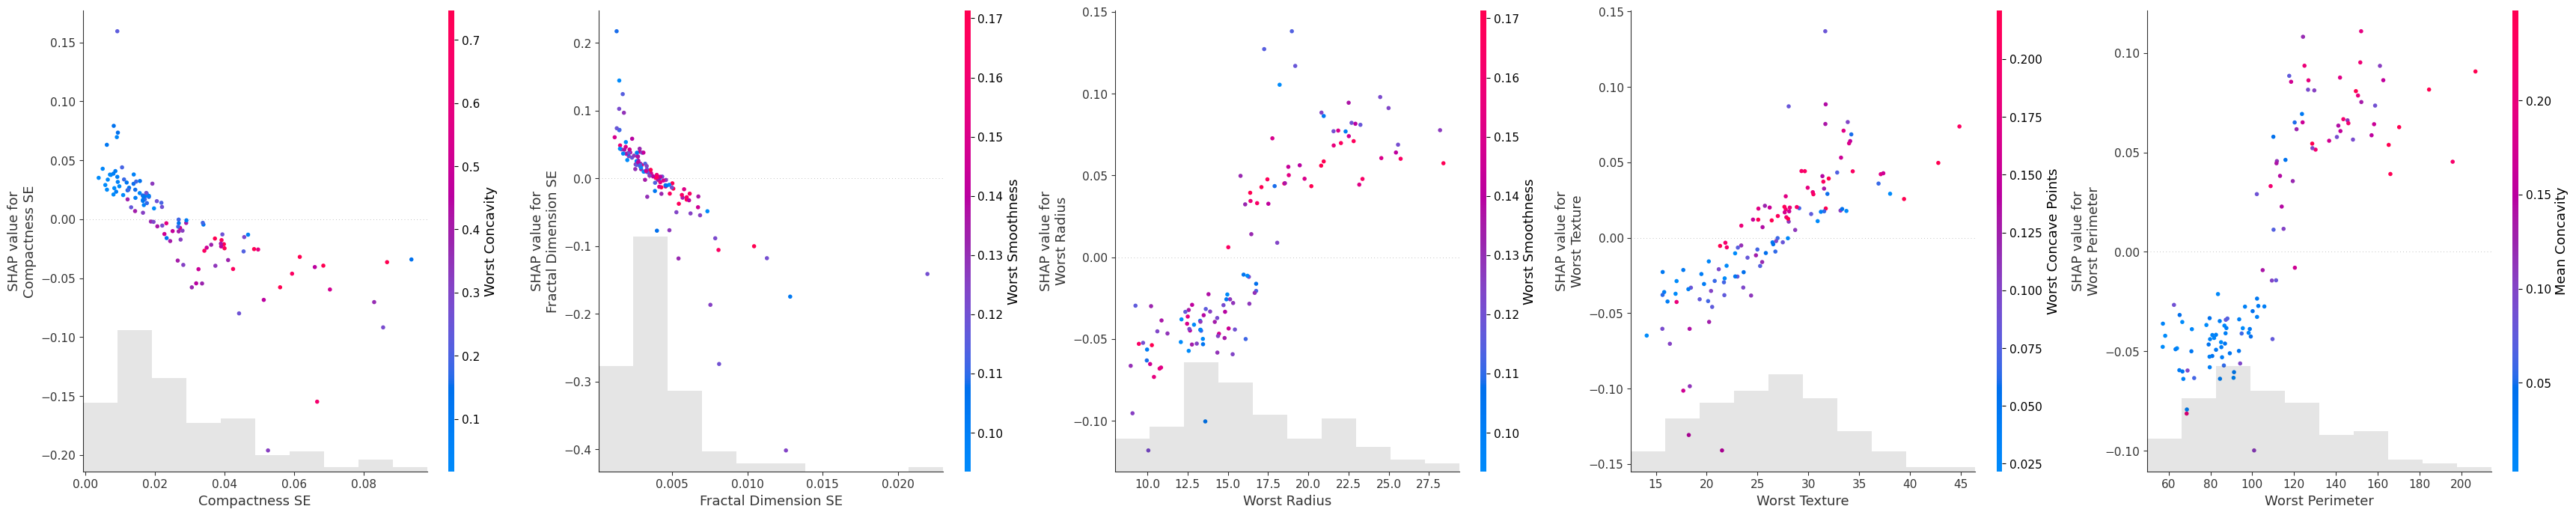

In [57]:
fig, axs = plt.subplots(1, 5, figsize=(43, 8))
shap.plots.scatter(shap_vals2[:, "Compactness SE", 1], color=shap_vals2[:,:,1], ax=axs[0], show = False)
shap.plots.scatter(shap_vals2[:, "Fractal Dimension SE", 1], color=shap_vals2[:,:,1], ax=axs[1], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Radius", 1], color=shap_vals2[:,:,1], ax=axs[2], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Texture", 1], color=shap_vals2[:,:,1], ax=axs[3], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Perimeter", 1], color=shap_vals2[:,:,1], ax=axs[4], show = False)

plt.show()

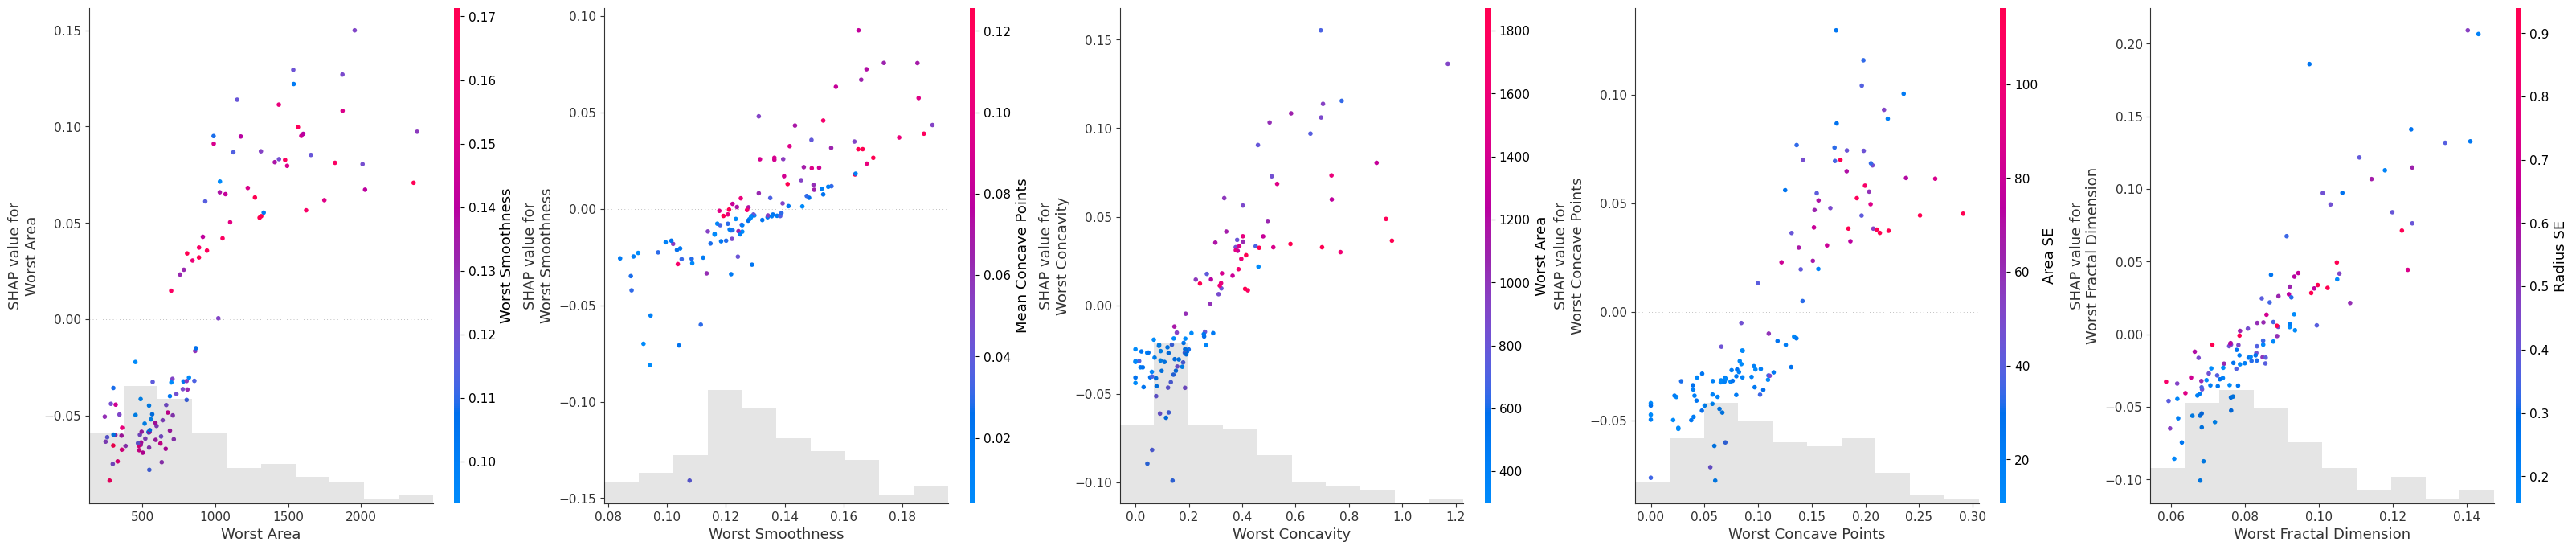

In [58]:
fig, axs = plt.subplots(1, 5, figsize=(40, 8))

shap.plots.scatter(shap_vals2[:, "Worst Area", 1], color=shap_vals2[:,:,1], ax=axs[0], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Smoothness", 1], color=shap_vals2[:,:,1], ax=axs[1], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Concavity", 1], color=shap_vals2[:,:,1], ax=axs[2], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Concave Points", 1], color=shap_vals2[:,:,1], ax=axs[3], show = False)
shap.plots.scatter(shap_vals2[:, "Worst Fractal Dimension", 1], color=shap_vals2[:,:,1], ax=axs[4], show = False)

plt.show()

## DiCE Prep

In [59]:
d = dice_ml.Data(dataframe=train_data2,
                 continuous_features=['Mean Texture', 'Mean Concavity', 'Mean Concave Points', 'Radius SE', 'Area SE', 'Compactness SE', 'Fractal Dimension SE', 'Worst Radius', 
                                      'Worst Texture', 'Worst Perimeter', 'Worst Area', 'Worst Smoothness', 'Worst Concavity', 'Worst Concave Points', 'Worst Fractal Dimension'],
                outcome_name='Diagnosis')
m = dice_ml.Model(model=model2, backend="sklearn")
exp = dice_ml.Dice(d,m,method="random")

## Range of Features

In [37]:
shap_selected_features.agg(['min', 'max'], axis=0)

,Diagnosis,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension
min,0,9.71,0.0000,0.0000,0.1115,6.802,0.002252,0.000895,7.93,12.02,50.41,185.2,0.07117,0.000,0.000,0.05504
max,1,39.28,0.4268,0.2012,2.8730,542.200,0.135400,0.029840,36.04,49.54,251.20,4254.0,0.22260,1.252,0.291,0.20750


# Case Studies

## Case Study of Malignant Case

In [67]:
print(X_test2.iloc[15])

Mean Texture                 11.890000
Mean Concavity                0.203200
Mean Concave Points           0.109700
Radius SE                     0.420900
Area SE                      44.640000
Compactness SE                0.023210
Fractal Dimension SE          0.004168
Worst Radius                 18.790000
Worst Texture                17.040000
Worst Perimeter             125.000000
Worst Area                 1102.000000
Worst Smoothness              0.153100
Worst Concavity               0.583000
Worst Concave Points          0.182700
Worst Fractal Dimension       0.101000
Name: 172, dtype: float64


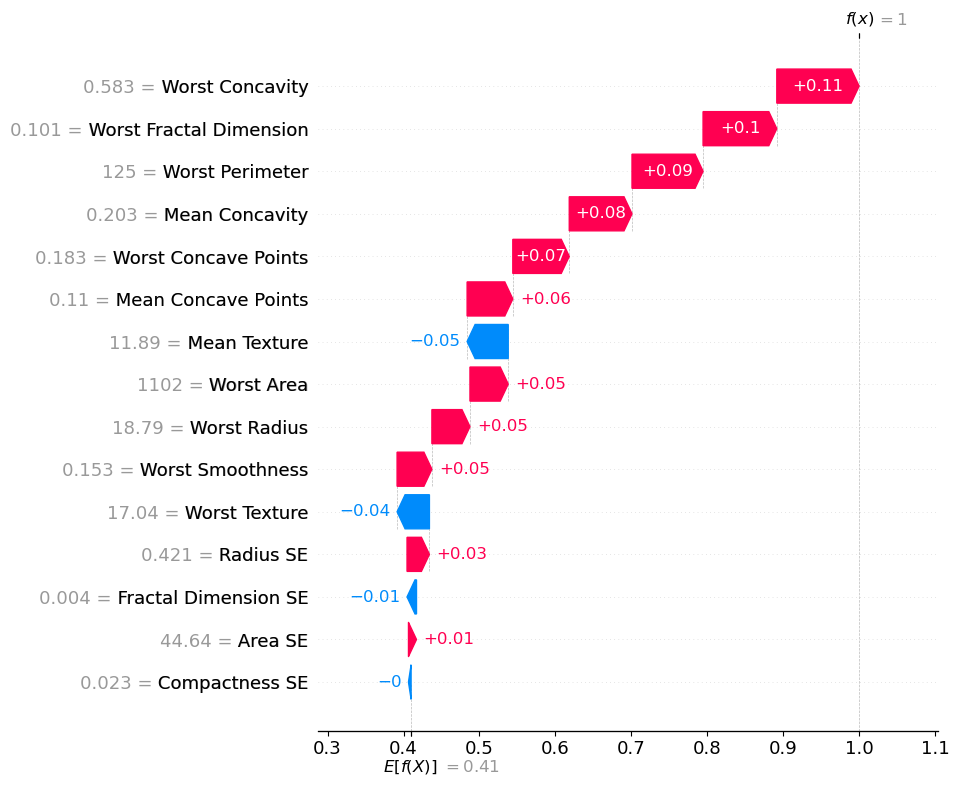

In [60]:
shap.plots.waterfall(shap_vals2[15,: ,1], max_display=15)

### General Counterfactuals

In [61]:
me_all = exp.generate_counterfactuals(X_test2[15:16], total_CFs=15, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
me_all.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.58it/s]

Query instance (original outcome : 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,11.89,0.2032,0.1097,0.4209,44.639999,0.02321,0.004168,18.790001,17.040001,125.0,1102.0,0.1531,0.583,0.1827,0.101,1



Diverse Counterfactual set (new outcome: 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,0.021796,-,-,-,-,-,-,0.3,-,0.0
1,-,-,-,-,-,-,0.020238,-,-,-,-,-,-,-,-,0.0
2,-,-,0.0,-,-,-,0.013215,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,0.025581,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,0.02931,14.73,-,-,-,-,-,-,-,0.0
5,25.16,-,-,-,-,-,0.021812,-,-,-,-,-,-,-,-,0.0
6,-,-,-,-,-,-,0.017616,-,-,-,-,-,-,-,-,0.0
7,-,-,-,-,-,-,0.021434,-,-,-,-,-,1.2,-,-,0.0
8,-,-,0.3,-,-,-,0.025282,-,-,-,-,-,-,-,-,0.0
9,-,-,-,0.421,-,-,0.024008,-,-,-,-,-,-,-,-,0.0


### No Counterfactuals found for: Mean Texture, Mean Concavity, Mean Concave Points, Radius SE, Area SE, Compactness SE, Worst Radius, Worst Texture, Worst Perimeter, Worst Area, Worst Smoothness, Worst Concavity, Worst Concave Points and Worst Fractal Dimension

### Counterfactuals for Fractal Dimension SE

In [62]:
me6 = exp.generate_counterfactuals(X_test2[15:16], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Fractal Dimension SE'],
                                  permitted_range={'Fractal Dimension SE': [0.000895,0.029840]})
me6.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  6.59it/s]

Query instance (original outcome : 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,11.89,0.2032,0.1097,0.4209,44.639999,0.02321,0.004168,18.790001,17.040001,125.0,1102.0,0.1531,0.583,0.1827,0.101,1



Diverse Counterfactual set (new outcome: 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,0.023005,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,0.018175,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,0.016815,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,0.028736,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,0.018234,-,-,-,-,-,-,-,-,0.0


## Case Study of Benign Case

In [38]:
print(X_test2.iloc[1])

Mean Texture                25.250000
Mean Concavity               0.027720
Mean Concave Points          0.020680
Radius SE                    0.208400
Area SE                     17.580000
Compactness SE               0.008082
Fractal Dimension SE         0.001828
Worst Radius                14.350000
Worst Texture               34.230000
Worst Perimeter             91.290000
Worst Area                 632.900000
Worst Smoothness             0.128900
Worst Concavity              0.139000
Worst Concave Points         0.060050
Worst Fractal Dimension      0.067880
Name: 457, dtype: float64


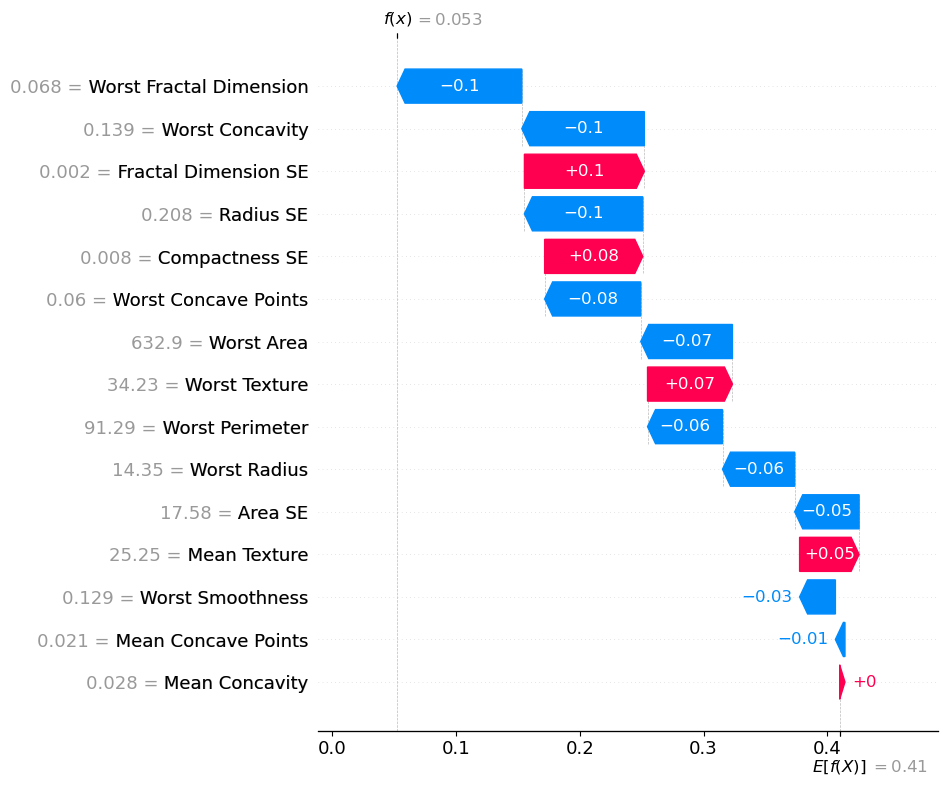

In [63]:
shap.plots.waterfall(shap_vals2[1,: ,1], max_display=15)

### General Counterfactuals

In [94]:
be_all = exp.generate_counterfactuals(X_test2[1:2], total_CFs=15, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
be_all.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.88it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,0.3,-,-,-,-,-,-,-,-,1688.6,-,-,-,-,1.0
1,-,-,-,-,-,-,0.001694,-,-,-,-,-,-,0.3,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.19444,1.0
3,-,-,-,-,516.24,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,2.401,-,-,-,-,-,-,-,-,-,-,-,1.0
5,-,-,-,-,-,0.00349,-,-,-,-,-,-,-,-,0.17341,1.0
6,-,0.2,-,-,-,-,-,35.89,-,-,-,-,-,-,-,1.0
7,-,-,-,-,251.09,-,-,-,-,-,-,-,0.6,-,-,1.0
8,-,-,-,2.36,-,-,-,-,-,-,-,0.1116,-,-,-,1.0
9,-,-,-,-,12.72,-,-,23.83,-,-,-,-,-,-,-,1.0


### No Counterfactuals Found for Mean Texture, Mean Concavity,Compactness SE,Fractal Dimension SE, Worst Texture, Worst Smoothness, Worst Concavity

### Counterfactuals for Mean Concave Points

In [99]:
be2 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Mean Concave Points'],
                                  permitted_range={'Mean Concave Points': [0.0000,0.2012]})
be2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  9.77it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,0.3,-,-,-,-,-,-,-,-,-,-,-,-,1.0


### Counterfactuals for Radius SE and Area SE

In [101]:
be3 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Radius SE'],
                                  permitted_range={'Radius SE': [0.1115,2.8730]})
be3.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  9.55it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,2.142,-,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,1.239,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,1.52,-,-,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,1.597,-,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,2.831,-,-,-,-,-,-,-,-,-,-,-,1.0


In [102]:
be4 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Area SE'],
                                  permitted_range={'Area SE': [6.802,542.2]})
be4.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  8.99it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,156.27,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,500.22,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,441.32,-,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,160.66,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,392.36,-,-,-,-,-,-,-,-,-,-,1.0


In [103]:
be5 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Radius SE', 'Area SE'],
                                  permitted_range={'Radius SE': [0.1115,2.8730], 'Area SE': [6.802,542.2]})
be5.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  6.64it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,226.92,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,2.797,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,2.52,397.3,-,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,1.678,166.52,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,1.421,32.95,-,-,-,-,-,-,-,-,-,-,1.0


### Counterfactuals for Worst Radius, Worst Perimeter, Worst Area

In [105]:
be7 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Worst Radius'],
                                  permitted_range={'Worst Radius':[7.93,36.04]})
be7.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  8.30it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,-,21.76,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,33.4,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,29.15,-,-,-,-,-,-,-,1.0
3,-,-,-,-,-,-,-,33.78,-,-,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,22.3,-,-,-,-,-,-,-,1.0


In [107]:
be8 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Worst Perimeter'],
                                  permitted_range={'Worst Perimeter':[50.41,251.20]})
be8.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  8.06it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,-,-,-,144.8,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,116.5,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,225.8,-,-,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,166.5,-,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,163.5,-,-,-,-,-,1.0


In [111]:
be9 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Worst Area'],
                                  permitted_range={'Worst Area':[185.2, 4254.0]})
be9.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  7.95it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,-,-,-,-,4233.7,-,-,-,-,1.0
1,-,-,-,-,-,-,-,-,-,-,3953.8,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,1404.6,-,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,3244.7,-,-,-,-,1.0
4,-,-,-,-,-,-,-,-,-,-,3640.1,-,-,-,-,1.0


In [125]:
be10 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Worst Radius', 'Worst Perimeter', 'Worst Area'],
                                  permitted_range={'Worst Radius':[7.93,36.04], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0]})
be10.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  6.58it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,-,21.56,-,-,-,-,-,-,-,1.0
1,-,-,-,-,-,-,-,15.65,-,178.0,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,2383.0,-,-,-,-,1.0
3,-,-,-,-,-,-,-,-,-,-,1986.6,-,-,-,-,1.0
4,-,-,-,-,-,-,-,23.09,-,-,936.0,-,-,-,-,1.0


### Counterfactuals for Worst Concave Points

In [126]:
be14 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Worst Concave Points'],
                                  permitted_range={'Worst Concave Points':[0.000,0.291]})
be14.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  9.25it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,-,-,-,-,-,-,-,0.2,-,1.0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,0.3,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,0.4,-,1.0


### Counterfactuals for Worst Fractal Dimension

In [128]:
be15 = exp.generate_counterfactuals(X_test2[1:2], total_CFs=5, desired_class="opposite",
                                  features_to_vary=['Worst Fractal Dimension'],
                                  permitted_range={'Worst Fractal Dimension':[0.05504,0.20750]})
be15.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  9.49it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.25,0.02772,0.02068,0.2084,17.58,0.008082,0.001828,14.35,34.23,91.290001,632.900024,0.1289,0.139,0.06005,0.06788,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.13752,1.0
1,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.19816,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.14337,1.0
3,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.14777,1.0
4,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.15076,1.0


# Extra Experiments and Plots

## Remove all High Contributing Features

In [7]:
df_worst_features = Breast_Cancer_df[['Mean Fractal Dimension', 'Concave Points SE', 'Symmetry SE', 'Texture SE', 'Smoothness SE', 'Concavity SE',
                                           'Worst Symmetry', 'Mean Symmetry', 'Mean Compactness', 'Mean Perimeter', 'Mean Area', 'Worst Compactness', 'Mean Smoothness', 
                                           'Perimeter SE', 'Mean Radius']].copy()

In [8]:
target3 = Breast_Cancer_df['Diagnosis'].copy()
X_train3, X_test3, y_train3, y_test3 = train_test_split(df_worst_features, target3, test_size=0.2, random_state=0)

mlp_clf3 = MLPClassifier(hidden_layer_sizes=(30, 20), activation='relu', solver='sgd',batch_size=32, alpha= 0.0001, learning_rate='constant', learning_rate_init=0.0550, 
                                 max_iter=95, momentum=0.95)
scaler3 = StandardScaler()
mlp_pipe3 = Pipeline([('scaler', scaler3), ('mlp', mlp_clf3)])

In [15]:
worst_features_scores = cross_validate(mlp_pipe3, X_train3, y_train3, scoring=('precision', 'recall', 'f1', 'accuracy'), cv=10, return_train_score=True)
print("test precision: ", worst_features_scores['test_precision'].mean())
print("test recall: ", worst_features_scores['test_recall'].mean())
print("test f1: ", worst_features_scores['test_f1'].mean())
print("test accuracy: ", worst_features_scores['test_accuracy'].mean())

print("train f1: ", worst_features_scores['train_f1'].mean())
print("train accuracy: ", worst_features_scores['train_accuracy'].mean())

test precision:  0.9359232026143791
test recall:  0.9334558823529413
test f1:  0.9331391605940942
test accuracy:  0.9516425120772947
train f1:  0.9993243166124521
train accuracy:  0.9995115987834694


In [66]:
mlp_pipe3.fit(X_train3, y_train3)
mlp_pipe3_predictions = mlp_pipe3.predict(X_test3)
print(mlp_pipe3_predictions)

[1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1 1 1 0 0 1 0 0 1 0 1 0 1 0 1 0 1 0
 1 0 1 0 0 1 0 1 1 0 0 0 1 1 1 1 0 0 0 0 0 0 1 1 1 0 0 1 0 1 1 1 0 1 1 0 0
 1 0 0 0 0 0 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 1 0 1 1 0
 1 1 0]


In [67]:
mlp_pipe3_precision = precision_score(y_test3, mlp_pipe3_predictions)
mlp_pipe3_recall = recall_score(y_test3, mlp_pipe3_predictions)
mlp_pipe3_f1 = f1_score(y_test3, mlp_pipe3_predictions)
mlp_pipe3_accuracy = mlp_pipe3.score(X_test3, y_test3)

print("Precision: ", mlp_pipe3_precision)
print("Recall: ", mlp_pipe3_recall)
print("f1: ", mlp_pipe3_f1)
print("Accuracy: ", mlp_pipe3_accuracy)

Precision:  0.88
Recall:  0.9361702127659575
f1:  0.9072164948453608
Accuracy:  0.9210526315789473


## More Cases

In [ ]:
print(X_test2.iloc[111])

Mean Texture                 19.540000
Mean Concavity                0.213300
Mean Concave Points           0.125900
Radius SE                     0.433100
Area SE                      52.490000
Compactness SE                0.027150
Fractal Dimension SE          0.004005
Worst Radius                 22.030000
Worst Texture                25.070000
Worst Perimeter             146.000000
Worst Area                 1479.000000
Worst Smoothness              0.166500
Worst Concavity               0.530800
Worst Concave Points          0.217300
Worst Fractal Dimension       0.080750
Name: 432, dtype: float64


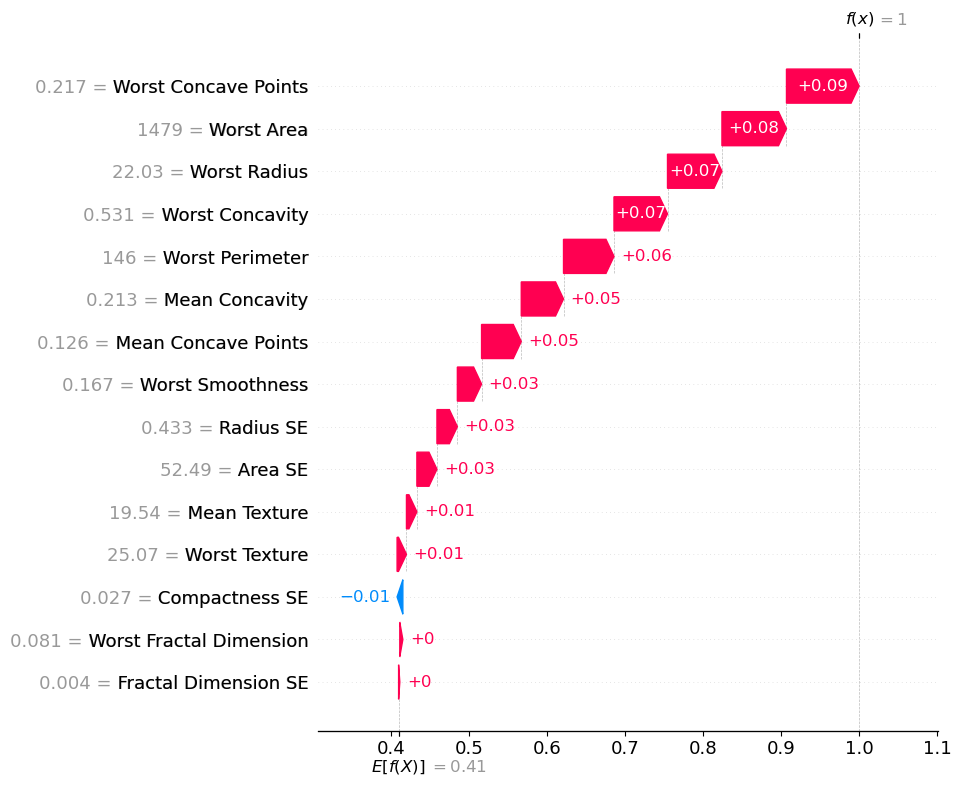

In [129]:
shap.plots.waterfall(shap_vals2[111,: ,1], max_display=15)

In [131]:
ex_111 = exp.generate_counterfactuals(X_test2[111:112], total_CFs=5, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_111.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.16it/s]

Query instance (original outcome : 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,19.540001,0.2133,0.1259,0.4331,52.490002,0.02715,0.004005,22.030001,25.07,146.0,1479.0,0.1665,0.5308,0.2173,0.08075,1



Diverse Counterfactual set (new outcome: 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,0.025466,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,0.029019,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,0.025477,-,-,-,-,-,0.7,-,-,0.0
3,-,-,-,-,-,-,0.029019,-,-,-,-,-,-,0.2,-,0.0
4,-,-,-,-,-,-,0.025307,20.94,-,-,-,-,-,-,-,0.0


In [81]:
print(X_test2.iloc[112])

Mean Texture                 20.580000
Mean Concavity                0.156900
Mean Concave Points           0.094510
Radius SE                     0.544900
Area SE                      67.360000
Compactness SE                0.018770
Fractal Dimension SE          0.002725
Worst Radius                 21.860000
Worst Texture                26.200000
Worst Perimeter             142.200000
Worst Area                 1493.000000
Worst Smoothness              0.149200
Worst Concavity               0.375900
Worst Concave Points          0.151000
Worst Fractal Dimension       0.078630
Name: 516, dtype: float64


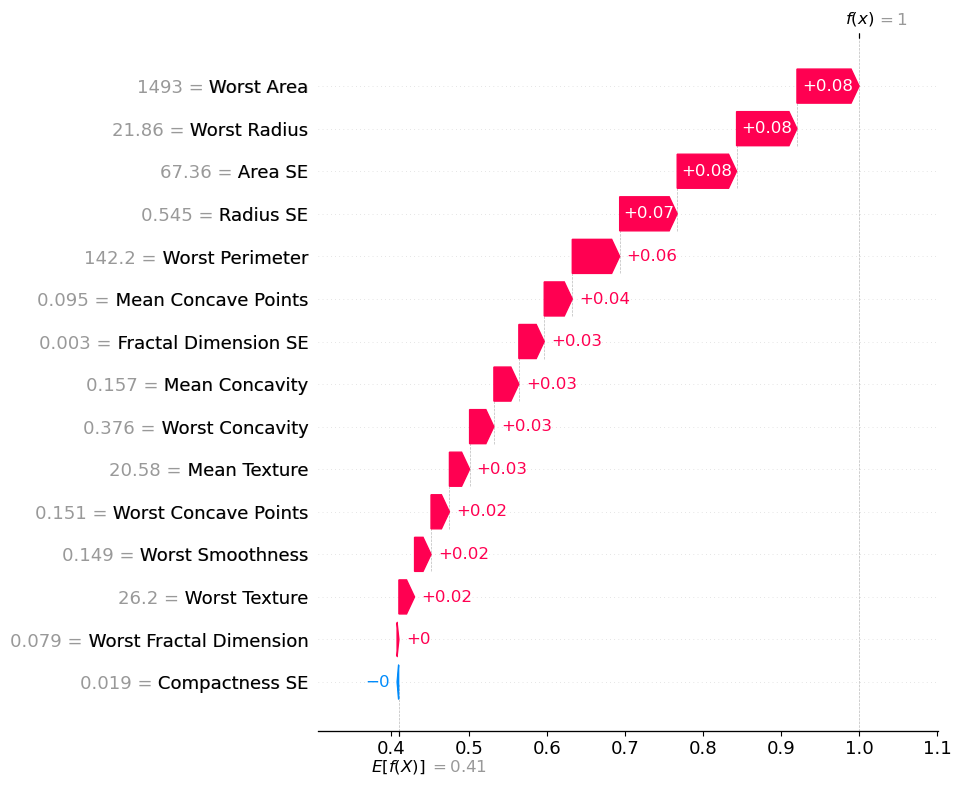

In [132]:
shap.plots.waterfall(shap_vals2[112,: ,1], max_display=15)

In [133]:
ex_112 = exp.generate_counterfactuals(X_test2[112:113], total_CFs=5, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_112.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  5.06it/s]

Query instance (original outcome : 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,20.58,0.1569,0.09451,0.5449,67.360001,0.01877,0.002725,21.860001,26.200001,142.199997,1493.0,0.1492,0.3759,0.151,0.07863,1



Diverse Counterfactual set (new outcome: 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,0.02733,-,39.25,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,0.023133,-,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,0.025292,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,0.024913,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,0.021003,-,-,-,-,-,-,-,-,0.0


In [120]:
print(X_test2.iloc[29])

Mean Texture                 21.430000
Mean Concavity                0.106000
Mean Concave Points           0.060900
Radius SE                     0.642200
Area SE                      88.250000
Compactness SE                0.038970
Fractal Dimension SE          0.004445
Worst Radius                 24.540000
Worst Texture                34.370000
Worst Perimeter             161.100000
Worst Area                 1873.000000
Worst Smoothness              0.149800
Worst Concavity               0.463400
Worst Concave Points          0.204800
Worst Fractal Dimension       0.098700
Name: 337, dtype: float64


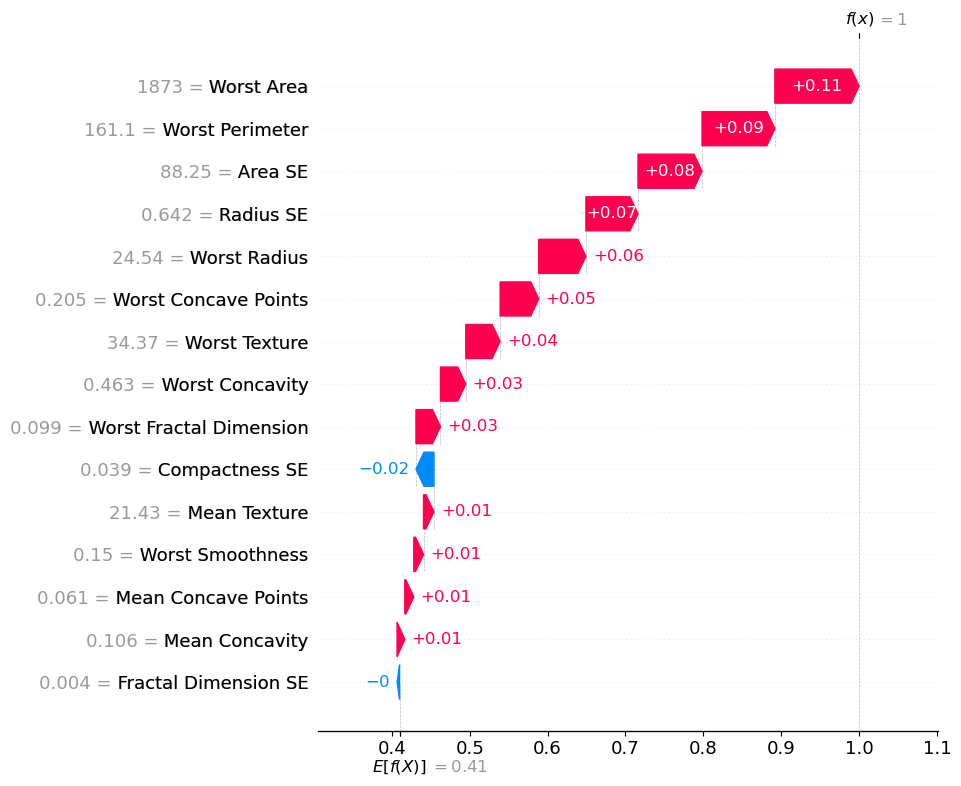

In [141]:
shap.plots.waterfall(shap_vals2[29,: ,1], max_display=15)

In [32]:
ex_29 = exp.generate_counterfactuals(X_test2[29:30], total_CFs=5, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_29.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.50it/s]

Query instance (original outcome : 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,21.43,0.106,0.0609,0.6422,88.25,0.03897,0.004445,24.540001,34.369999,161.100006,1873.0,0.1498,0.4634,0.2048,0.0987,1



Diverse Counterfactual set (new outcome: 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,-,-,-,0.027772,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,0.027772,-,-,-,-,-,0.3,-,-,0.0
2,-,-,-,-,-,-,0.02709,-,-,-,-,-,-,-,-,0.0
3,-,-,-,-,-,-,0.029628,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,0.00692,0.026178,-,-,-,-,-,-,-,-,0.0


In [116]:
print(X_test2.iloc[39])

Mean Texture                 25.740000
Mean Concavity                0.123500
Mean Concave Points           0.065530
Radius SE                     0.653400
Area SE                      63.370000
Compactness SE                0.024310
Fractal Dimension SE          0.004867
Worst Radius                 18.510000
Worst Texture                33.220000
Worst Perimeter             121.200000
Worst Area                 1050.000000
Worst Smoothness              0.166000
Worst Concavity               0.402900
Worst Concave Points          0.152600
Worst Fractal Dimension       0.094380
Name: 353, dtype: float64


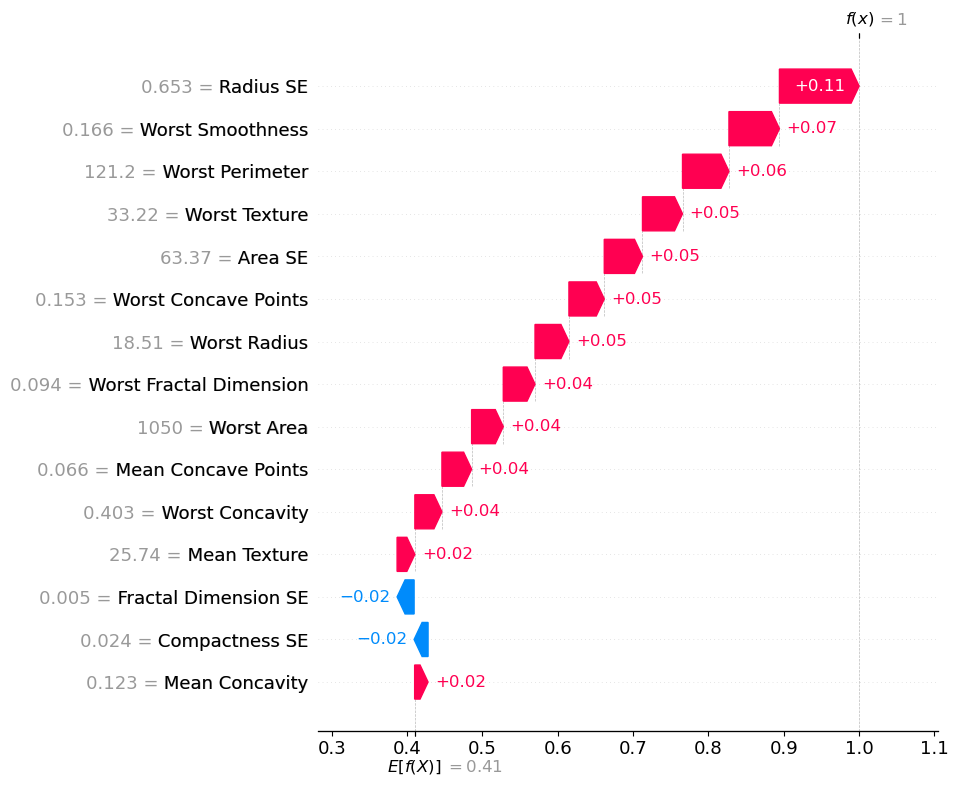

In [143]:
shap.plots.waterfall(shap_vals2[39,: ,1], max_display=15)

In [144]:
ex_39 = exp.generate_counterfactuals(X_test2[39:40], total_CFs=5, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_39.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.99it/s]

Query instance (original outcome : 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.74,0.1235,0.06553,0.6534,63.369999,0.02431,0.004867,18.51,33.220001,121.199997,1050.0,0.166,0.4029,0.1526,0.09438,1



Diverse Counterfactual set (new outcome: 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,0.1,-,-,-,0.022539,-,-,-,-,-,-,-,-,0.0
1,-,-,-,-,-,-,0.022027,17.88,-,-,-,-,-,-,-,0.0
2,-,-,-,-,-,-,0.027721,-,-,-,-,-,-,-,-,0.0
3,-,-,0.1,-,-,-,0.021477,-,-,-,-,-,-,-,-,0.0
4,-,-,-,-,-,-,0.025185,-,-,-,-,-,-,-,-,0.0


In [23]:
print(X_test2.iloc[2])

Mean Texture                15.660000
Mean Concavity               0.020870
Mean Concave Points          0.026520
Radius SE                    0.214200
Area SE                     19.250000
Compactness SE               0.009238
Fractal Dimension SE         0.002104
Worst Radius                14.910000
Worst Texture               19.310000
Worst Perimeter             96.530000
Worst Area                 688.900000
Worst Smoothness             0.103400
Worst Concavity              0.062600
Worst Concave Points         0.082160
Worst Fractal Dimension      0.067100
Name: 439, dtype: float64


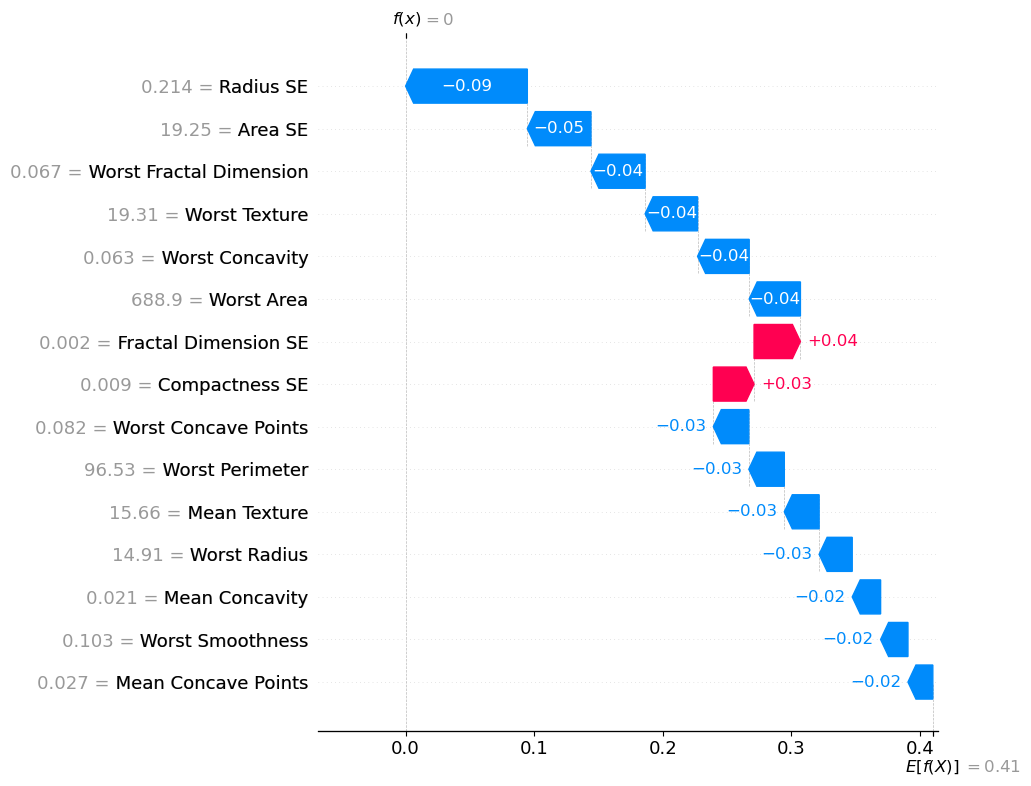

In [145]:
shap.plots.waterfall(shap_vals2[2,: ,1], max_display=15)

In [147]:
ex_2 = exp.generate_counterfactuals(X_test2[2:3], total_CFs=10, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_2.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.86it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,15.66,0.02087,0.02652,0.2142,19.25,0.009238,0.002104,14.91,19.309999,96.529999,688.900024,0.1034,0.0626,0.08216,0.0671,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,2.251,-,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,361.58,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,-,-,-,-,-,-,-,-,-,-,-,0.19915,1.0
3,-,-,-,-,65.54,-,-,-,-,-,-,-,-,-,0.14849,1.0
4,-,-,-,-,174.78,-,-,-,-,-,-,-,-,-,-,1.0
5,-,-,-,-,-,-,-,-,-,-,3105.6,-,-,0.3,-,1.0
6,-,0.3,-,-,-,-,-,-,-,-,-,-,-,-,0.1471,1.0
7,-,-,-,0.867,-,-,-,23.72,-,-,-,-,-,-,-,1.0
8,-,-,-,-,-,-,-,25.35,-,-,3660.7,-,-,-,-,1.0
9,-,0.1,-,1.555,-,-,-,-,-,-,-,-,-,-,-,1.0


In [24]:
print(X_test2.iloc[1])

Mean Texture                25.250000
Mean Concavity               0.027720
Mean Concave Points          0.020680
Radius SE                    0.208400
Area SE                     17.580000
Compactness SE               0.008082
Fractal Dimension SE         0.001828
Worst Radius                14.350000
Worst Texture               34.230000
Worst Perimeter             91.290000
Worst Area                 632.900000
Worst Smoothness             0.128900
Worst Concavity              0.139000
Worst Concave Points         0.060050
Worst Fractal Dimension      0.067880
Name: 457, dtype: float64


In [69]:
print(X_test2.iloc[8])

Mean Texture                25.490000
Mean Concavity               0.000000
Mean Concave Points          0.000000
Radius SE                    0.377700
Area SE                     19.140000
Compactness SE               0.009692
Fractal Dimension SE         0.006872
Worst Radius                 9.077000
Worst Texture               30.920000
Worst Perimeter             57.170000
Worst Area                 248.000000
Worst Smoothness             0.125600
Worst Concavity              0.000000
Worst Concave Points         0.000000
Worst Fractal Dimension      0.099380
Name: 538, dtype: float64


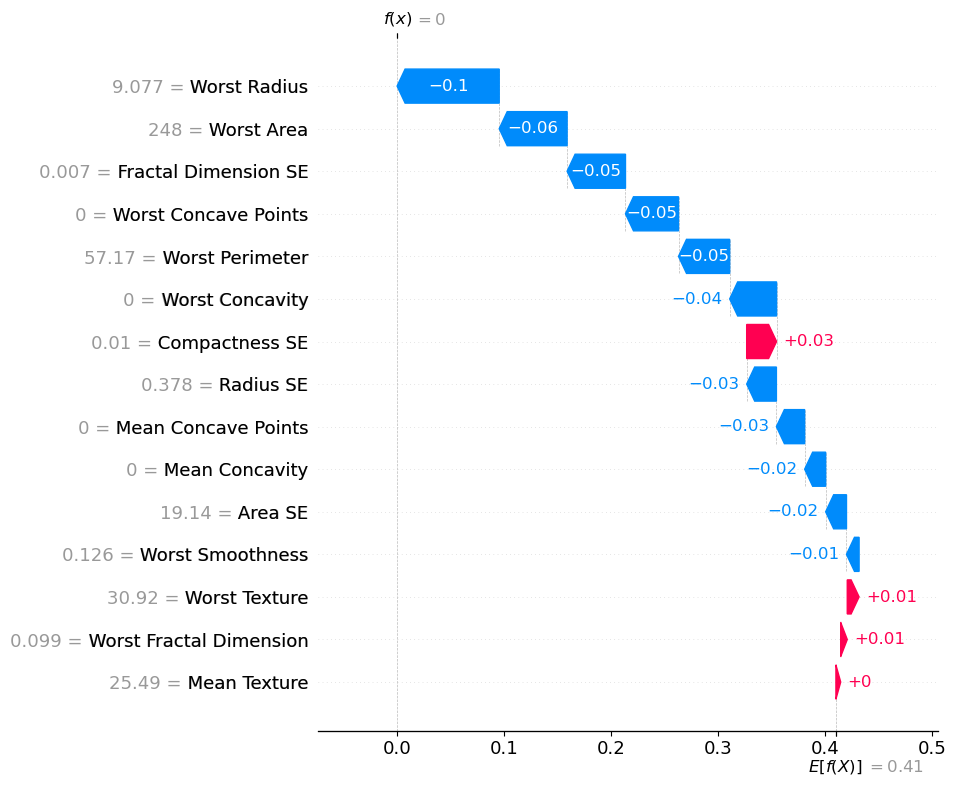

In [148]:
shap.plots.waterfall(shap_vals2[8,: ,1], max_display=15)

In [150]:
ex_8 = exp.generate_counterfactuals(X_test2[8:9], total_CFs=10, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_8.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.94it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,25.49,0.0,0.0,0.3777,19.139999,0.009692,0.006872,9.077,30.92,57.169998,248.0,0.1256,0.0,0.0,0.09938,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,2.293,-,-,-,-,-,-,4219.9,-,-,-,-,1.0
1,-,-,0.2,1.337,-,-,-,-,-,-,-,-,-,-,-,1.0
2,-,-,-,2.486,-,-,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,498.64,-,-,34.06,-,-,-,-,-,-,-,1.0
4,-,-,-,-,107.03,-,-,34.03,-,-,-,-,-,-,-,1.0
5,-,-,-,2.793,-,-,-,-,-,-,2875.6,-,-,-,-,1.0
6,-,-,-,-,530.42,-,-,-,-,-,-,-,-,-,-,1.0
7,-,-,-,-,-,-,-,-,-,-,2887.1,-,-,-,0.20456,1.0
8,-,-,-,-,513.31,0.13253,-,-,-,-,-,-,-,-,-,1.0
9,-,-,0.2,-,-,-,-,33.58,-,-,-,-,-,-,-,1.0


In [75]:
print(X_test2.iloc[46])

Mean Texture                14.450000
Mean Concavity               0.000000
Mean Concave Points          0.000000
Radius SE                    0.220400
Area SE                     11.360000
Compactness SE               0.008007
Fractal Dimension SE         0.003399
Worst Radius                 9.262000
Worst Texture               17.040000
Worst Perimeter             58.360000
Worst Area                 259.200000
Worst Smoothness             0.116200
Worst Concavity              0.000000
Worst Concave Points         0.000000
Worst Fractal Dimension      0.078480
Name: 175, dtype: float64


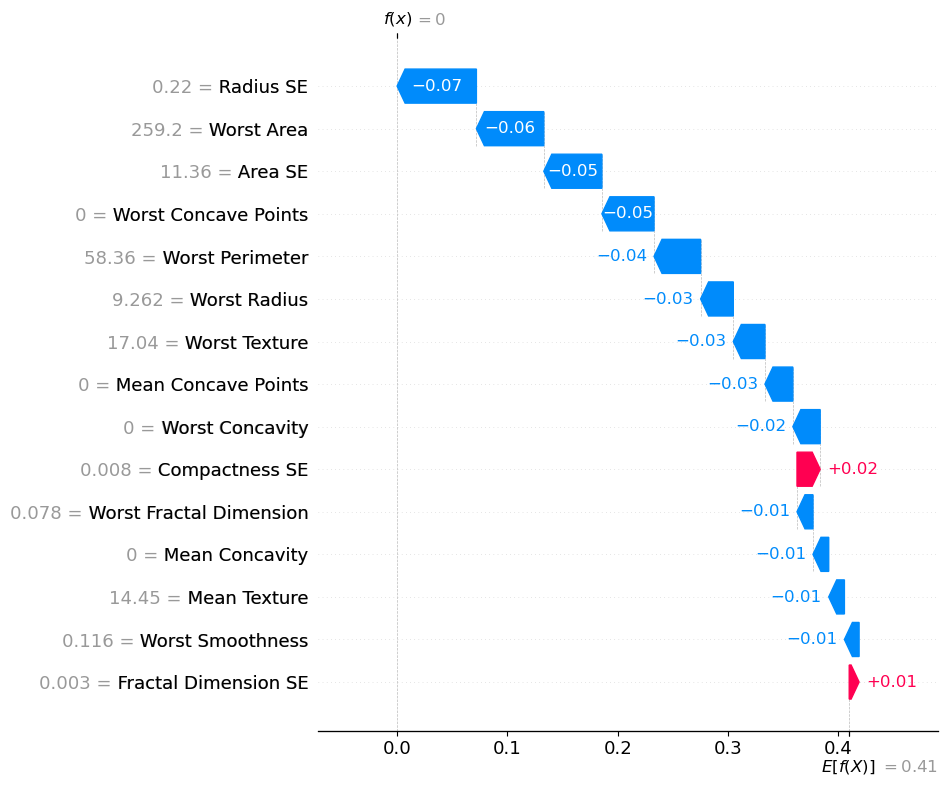

In [151]:
shap.plots.waterfall(shap_vals2[46,: ,1], max_display=15)

In [153]:
ex_46 = exp.generate_counterfactuals(X_test2[46:47], total_CFs=10, desired_class="opposite",
                                   permitted_range={'Mean Texture':[9.71, 39.28], 'Mean Concavity': [0.0000,0.4268], 'Mean Concave Points': [0.0000,0.2012], 'Radius SE': [0.1115,2.8730], 
                                                    'Area SE': [6.802,542.2], 'Compactness SE':[0.002252,0.1354], 'Fractal Dimension SE': [0.000895,0.029840], 'Worst Radius':[7.93,36.04], 
                                                    'Worst Texture': [12.02,49.54], 'Worst Perimeter':[50.41,251.20], 'Worst Area':[185.2, 4254.0], 'Worst Smoothness':[0.07117,0.22260], 
                                                    'Worst Concavity':[0.000,1.252], 'Worst Concave Points':[0.000,0.291], 'Worst Fractal Dimension':[0.05504,0.20750]})
ex_46.visualize_as_dataframe(show_only_changes=True)

100%|██████████| 1/1 [00:00<00:00,  3.73it/s]

Query instance (original outcome : 0)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,14.45,0.0,0.0,0.2204,11.36,0.008007,0.003399,9.262,17.040001,58.360001,259.200012,0.1162,0.0,0.0,0.07848,0



Diverse Counterfactual set (new outcome: 1)


,Mean Texture,Mean Concavity,Mean Concave Points,Radius SE,Area SE,Compactness SE,Fractal Dimension SE,Worst Radius,Worst Texture,Worst Perimeter,Worst Area,Worst Smoothness,Worst Concavity,Worst Concave Points,Worst Fractal Dimension,Diagnosis
0,-,-,-,1.678,-,-,-,-,-,-,-,-,-,-,-,1.0
1,-,-,-,-,380.19,-,-,-,27.6,-,-,-,-,-,-,1.0
2,-,-,-,-,516.64,-,-,-,-,-,-,-,-,-,-,1.0
3,-,-,-,-,415.07,-,-,-,-,-,-,-,-,-,-,1.0
4,-,-,-,-,364.03,-,-,-,-,-,-,-,-,-,0.19773,1.0
5,-,-,-,-,-,-,-,-,-,-,2699.9,-,-,-,0.20035,1.0
6,-,-,-,2.7,-,-,-,-,-,135.4,-,-,-,-,-,1.0
7,-,-,-,-,362.51,-,-,-,-,-,-,-,-,-,-,1.0
8,-,-,-,-,311.38,-,-,-,-,-,-,-,-,-,-,1.0
9,-,-,-,-,176.57,-,-,33.61,-,-,-,-,-,-,-,1.0
